# NeutraHMC on a Banana Gaussian Distribution

In [1]:
import argparse
import logging

import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

import pyro
from pyro import optim, poutine
import pyro.distributions as dist
from pyro.distributions import constraints
from pyro.infer import MCMC, NUTS, SVI, Trace_ELBO
from pyro.infer.reparam import NeuTraReparam

%matplotlib inline

## Defining the Distribution and Model

In [2]:
class BananaGaussian(dist.TorchDistribution):
    support = constraints.real_vector

    def __init__(self, a, b, rho=0.9):
        self.a = a 
        self.b = b
        self.rho = rho
        self.mvn = dist.MultivariateNormal(torch.tensor([0., 0.]), 
                                           covariance_matrix=torch.tensor([[1., self.rho], [self.rho, 1.]]))
        super().__init__(event_shape=(2,))

    def sample(self, sample_shape=()):
        u = self.mvn.sample(sample_shape)
        u0, u1 = u[..., 0], u[..., 1]
        a, b = self.a, self.b
        x = a * u0 
        y = (u1 / a) + b * (u0 ** 2 + a ** 2)
        return torch.stack([x, y], -1)

    def log_prob(self, x):
        x, y = x[..., 0], x[..., 1]
        a, b = self.a, self.b
        u0 = x / a
        u1 = (y - b * (u0 ** 2 + a ** 2)) * a
        return self.mvn.log_prob(torch.stack([u0, u1], dim=-1))

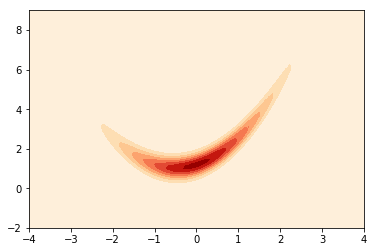

In [3]:
x1 = torch.linspace(-4, 4, 100)
x2 = torch.linspace(-2, 9, 100)
X1, X2 = torch.meshgrid([x1, x2])
d0 = BananaGaussian(1.15, 0.9)  # more extreme case try (1.15, 1.96)
P = torch.exp(d0.log_prob(torch.stack([X1, X2], dim=-1)))
plt.contourf(X1, X2, P, cmap='OrRd');

In [4]:
def model(a, b, rho=0.9):
    pyro.sample('x', BananaGaussian(a, b, rho))

## Run Vanilla HMC

In [5]:
pyro.set_rng_seed(0)

nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, warmup_steps=500, num_samples=1000)
mcmc.run(1.15, 0.9)
mcmc.summary()

Sample: 100%|██████████| 1500/1500 [00:14, 101.98it/s, step size=2.01e-01, acc. prob=0.877]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      x[0]     -0.18      1.05     -0.11     -1.85      1.55     97.06      1.00
      x[1]      1.85      1.03      1.58      0.48      3.55    162.93      1.00

Number of divergences: 4


In [6]:
vanilla_samples = mcmc.get_samples()['x'].detach().numpy()

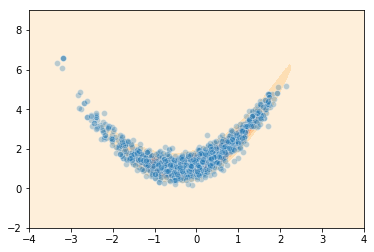

In [7]:
f, ax = plt.subplots(1, 1)
ax.contourf(X1, X2, P, cmap='OrRd')
sns.scatterplot(vanilla_samples[:, 0], vanilla_samples[:, 1], alpha=0.3, ax=ax);

## Fit a BNAF autoguide

In [10]:
from functools import partial

from pyro.distributions.transforms import block_autoregressive, iterated
from pyro.infer.autoguide import AutoNormalizingFlow

In [11]:
pyro.clear_param_store()
pyro.set_rng_seed(1)

adam = optim.Adam({'lr': 1e-2})
guide = AutoNormalizingFlow(model, partial(iterated, 1, block_autoregressive))
svi = SVI(model, guide, adam, Trace_ELBO())
for i in range(6000):
    loss = svi.step(1.15, 0.9)
    if i % 500 == 0:
        print("[{}]Elbo loss = {:.2f}".format(i, loss))

[0]Elbo loss = -0.24
[500]Elbo loss = 0.83
[1000]Elbo loss = 0.27
[1500]Elbo loss = 0.31
[2000]Elbo loss = 0.17
[2500]Elbo loss = 0.20
[3000]Elbo loss = 2.32
[3500]Elbo loss = 0.45
[4000]Elbo loss = -0.09
[4500]Elbo loss = -0.11
[5000]Elbo loss = 0.59
[5500]Elbo loss = 0.40


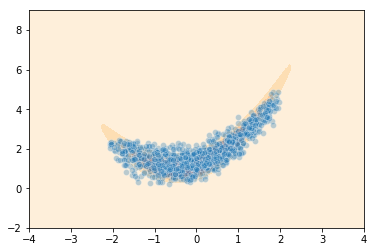

In [12]:
with pyro.plate('N', 1000):
    guide_samples = guide()['x'].detach().numpy()

f, ax = plt.subplots(1, 1)
ax.contourf(X1, X2, P, cmap='OrRd')
sns.scatterplot(guide_samples[:, 0], guide_samples[:, 1], alpha=0.3, ax=ax);

## Sample from NeutraHMC

In [13]:
guide = guide.requires_grad_(False)
neutra = NeuTraReparam(guide)
neutra_model = poutine.reparam(model, config=lambda _: neutra)

In [14]:
pyro.set_rng_seed(2)


nuts_kernel = NUTS(neutra_model)
mcmc = MCMC(nuts_kernel, 500, 1000)
mcmc.run(0.15, 0.9)
mcmc.summary()

Sample: 100%|██████████| 1500/1500 [00:32, 45.62it/s, step size=6.46e-01, acc. prob=0.884]


                        mean       std    median      5.0%     95.0%     n_eff     r_hat
x_shared_latent[0]      0.02      0.07      0.02     -0.10      0.11    235.37      1.00
x_shared_latent[1]     -0.90      3.60     -0.32     -6.09      5.02    255.98      1.00

Number of divergences: 0


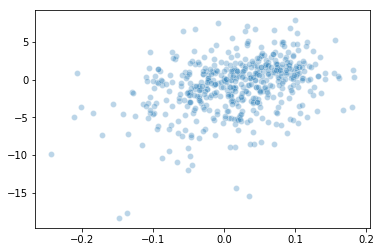

In [31]:
zs = mcmc.get_samples()["x_shared_latent"]
sns.scatterplot(zs[:, 0], zs[:, 1], alpha=0.3);

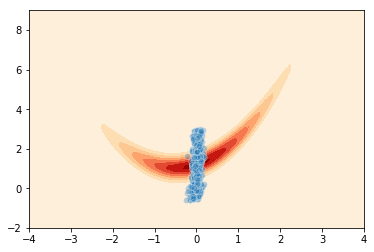

In [15]:
zs = mcmc.get_samples()["x_shared_latent"]
samples = neutra.transform_sample(zs)
zs = zs.detach().numpy()
samples = samples['x'].detach().numpy()

f, ax = plt.subplots(1, 1)
ax.contourf(X1, X2, P, cmap='OrRd')
sns.scatterplot(samples[:, 0], samples[:, 1], alpha=0.3, ax=ax);

### Visualize the potential energy

In [18]:
from pyro.infer.mcmc.util import initialize_model

In [20]:
_, get_potential_fn, _, _ = initialize_model(neutra_model, model_args=(0.15, 0.9))

torch.Size([10000])


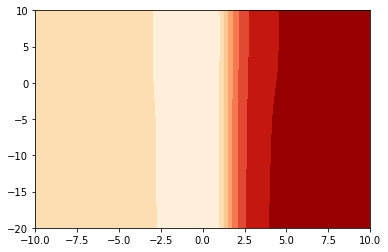

In [35]:
x1 = torch.linspace(-10, 10, 100)
x2 = torch.linspace(-20, 10, 100)
xm1, xm2 = torch.meshgrid([x1, x2])
# Inefficient; should be easy to add dim arg to get_potential_fn
pm = [get_potential_fn({'x_shared_latent': torch.stack([xm1[i, j], xm2[i, j]])}) 
      for i in range(100) for j in range(100)]
print(torch.stack(pm).shape)
pm = torch.stack(pm).reshape(100, 100)
plt.contourf(xm1, xm2, pm, cmap='OrRd');